In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymdp

from pymdp.utils import obj_array, obj_array_uniform, random_B_matrix

from sim import Sim
from utils import softmax_temperature

In [3]:
num_modalities       = 1  # [Play action obs]
num_factors          = 1  # [Play action state]
num_actions          = 2  # [C, D]
num_obs_categories   = 4  # [CC, CD, DC, DD]
num_state_categories = 4  # [CC, CD, DC, DD]

In [4]:
# A_temp_range = [0.5, 3.2]  # Medium noise
A_temp_range = [7, 8]   # Deterministic

""" Agent 0 """
# A_temp_k0 = np.random.uniform(A_temp_range[0], A_temp_range[1])
A_k0 = obj_array(num_modalities)
# A_k0[0] = softmax_temperature(x=np.eye(num_obs_categories), temp=A_temp_k0)
A_k0[0] = np.eye(num_obs_categories)

B_k0 = obj_array(num_factors)
# B_k0[0] = np.tile(0.25, (4, 4, 2))
B_k0[0] = np.zeros((4, 4, 2))
B_k0[0][0, :, 0] = np.tile(0.5, 4)
B_k0[0][1, :, 0] = np.tile(0.5, 4)
B_k0[0][2, :, 1] = np.tile(0.5, 4)
B_k0[0][3, :, 1] = np.tile(0.5, 4)

C_k0 = obj_array(num_modalities)
C_k0[0] = np.array([3, 1, 4, 2])

# D_k0 = obj_array(num_factors)
# D_k0[0] = np.array([0.2, 0.05, 0.65, 0.1])
D_k0 = obj_array_uniform([num_state_categories])

ef_k0 = np.array([0.9, 0.1])

""" Agent 1 """
# A_temp_k1 = np.random.uniform(A_temp_range[0], A_temp_range[1])
A_k1 = obj_array(num_modalities)
# A_k1[0] = softmax_temperature(x=np.eye(num_obs_categories), temp=A_temp_k1)
A_k1[0] = np.eye(num_obs_categories)

B_k1 = obj_array(num_factors)
B_k1[0] = np.zeros((4, 4, 2))
B_k1[0][0, :, 0] = np.tile(0.5, 4)
B_k1[0][2, :, 0] = np.tile(0.5, 4)
B_k1[0][1, :, 1] = np.tile(0.5, 4)
B_k1[0][3, :, 1] = np.tile(0.5, 4)

C_k1 = obj_array(num_modalities)
C_k1[0] = np.array([3, 4, 1, 2])

# D_k1 = obj_array(num_factors)
# D_k1[0] = np.array([0.2, 0.05, 0.65, 0.1])
D_k1 = obj_array_uniform([num_state_categories])

ef_k1 = np.array([1, 0])

In [5]:
config = {
    "T": 150,
    "K": 2,
    "A": [A_k0, A_k1],
    "B": [B_k0, B_k1],
    "C": [C_k0, C_k1],
    "D": [D_k0, D_k1], 
    "empathy_factor": [ef_k0, ef_k1],
    "actions": ["C", "D"],
    "learn": True,
    "policy_len": 2,
    "same_pref" : False
}

<Figure size 640x480 with 0 Axes>

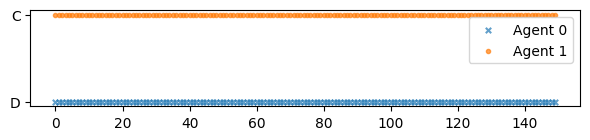

In [6]:
simulation = Sim(config=config)
history = simulation.run(verbose=False)

T = config["T"]
actions_k0 = history["results"]["action"][:, 0]
actions_k1 = history["results"]["action"][:, 1]
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1), figsize=(6,1.5))

ax.scatter(
    range(T), 
    [config["actions"][int(u)] for u in actions_k0], 
    alpha=0.7, s=15, marker="x", label="Agent 0")

ax.scatter(
    range(T), 
    [config["actions"][int(u)] for u in actions_k1], 
    alpha=0.7, s=9, label="Agent 1")

# ax.plot(range(T), np.argmax(history["results"]["qs"][:, 0, :], axis=1), label="Agent 0")
# ax.plot(range(T), np.argmax(history["results"]["qs"][:, 1, :], axis=1), label="Agent 1")

# ax.plot(range(T), history["results"]["G"][:, 0, 0], label="Agent 0, policy 1")
# ax.plot(range(T), history["results"]["G"][:, 1, 0], label="Agent 1, policy 1")
# ax.plot(range(T), history["results"]["G"][:, 0, 1], label="Agent 0, policy 2")
# ax.plot(range(T), history["results"]["G"][:, 1, 1], label="Agent 1, policy 2")

# ax.plot(range(T), history["results"]["q_pi"][:, 0, 0], label="Agent 0, CC")
# ax.plot(range(T), history["results"]["q_pi"][:, 0, 2], label="Agent 0, DC")
# ax.plot(range(T), history["results"]["q_pi"][:, 1, 0], label="Agent 1, CC")
# ax.plot(range(T), history["results"]["q_pi"][:, 1, 2], label="Agent 1, DC")

plt.legend(frameon=True)
fig.tight_layout()

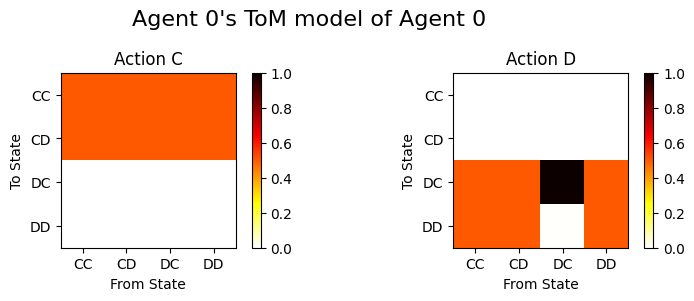

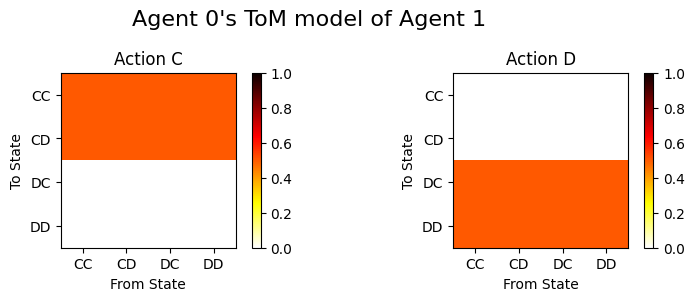

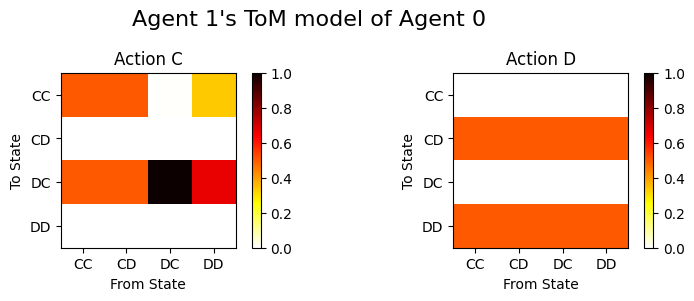

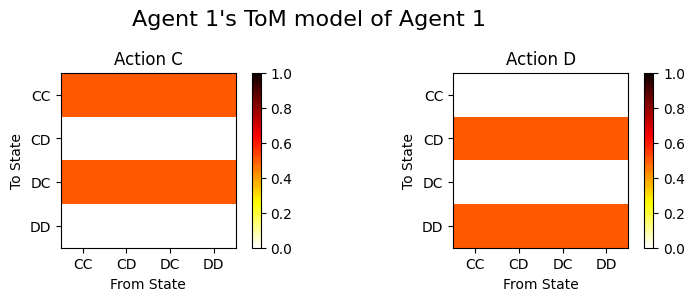

In [7]:
for agent_idx in range(2):
    for tom in range(2):
        B = simulation.agents[agent_idx].agents[tom].B[0]  # shape: (4, 4, 2)
        fig, axes = plt.subplots(1, B.shape[2], figsize=(8, 3))
        fig.suptitle(f"Agent {agent_idx}'s ToM model of Agent {tom}", fontsize=16)
        state_labels = ['CC', 'CD', 'DC', 'DD']
        action_labels = config["actions"]
        for action in range(B.shape[2]):
            ax = axes[action] if B.shape[2] > 1 else axes
            im = ax.imshow(B[:, :, action], cmap='hot_r', vmin=0, vmax=1)
            ax.set_title(f"Action {action_labels[action]}")
            ax.set_xlabel("From State")
            ax.set_ylabel("To State")
            ax.set_xticks(range(len(state_labels)))
            ax.set_yticks(range(len(state_labels)))
            ax.set_xticklabels(state_labels)
            ax.set_yticklabels(state_labels)
            fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()